In [ ]:
from google.colab import auth, files, drive
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bqclient = bigquery.Client(credentials=credentials, project="datafall-fulfillment")
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [ ]:
#query_string = """select * from `datafall-fulfillment.model_v0.fct_incentives_v1` LIMIT 500000"""
#df = bqclient.query(query_string).result().to_dataframe()
df.to_csv('last500.csv')

EDA

In [ ]:
track_counts=pd.DataFrame(df.groupby(by=["incentive_type"], dropna=False)['incentive_track_uuid'].nunique()).reset_index().sort_values(by='incentive_track_uuid', ascending=False)

Text(0.5, 1.0, 'Number of Incentive Tracks')

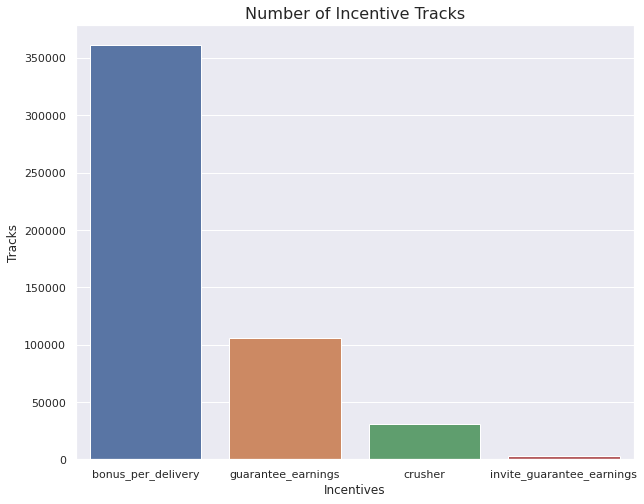

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x="incentive_type", y="incentive_track_uuid", data=track_counts)
plt.ylabel("Tracks", fontsize=12)
plt.xlabel("Incentives",fontsize=12)
plt.title("Number of Incentive Tracks",fontsize=16)

Text(0.5, 1.0, 'Total payout for each incentive type')

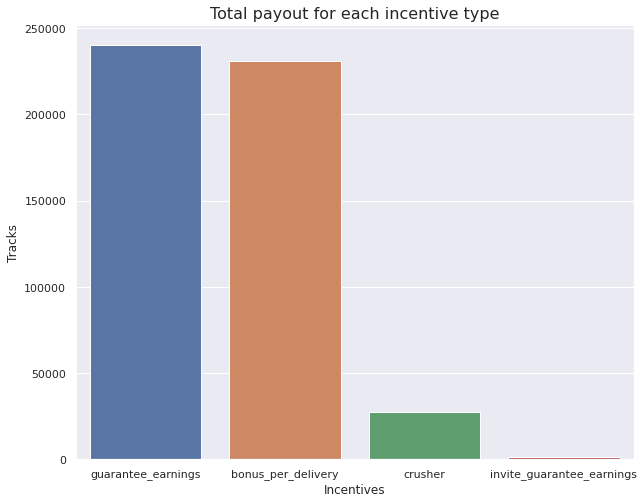

In [ ]:
track_mdeian=pd.DataFrame(df.groupby(by=["incentive_type"], dropna=False)['payout_amount'].median()).reset_index().sort_values(by='payout_amount', ascending=False)
sns.set(rc={'figure.figsize':(10,8)})
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x="incentive_type", y="incentive_track_uuid", data=track_counts)
plt.ylabel("Tracks", fontsize=12)
plt.xlabel("Incentives",fontsize=12)
plt.title("Total payout for each incentive type",fontsize=16)

Text(0.5, 1.0, 'Total payout for each incentive type')

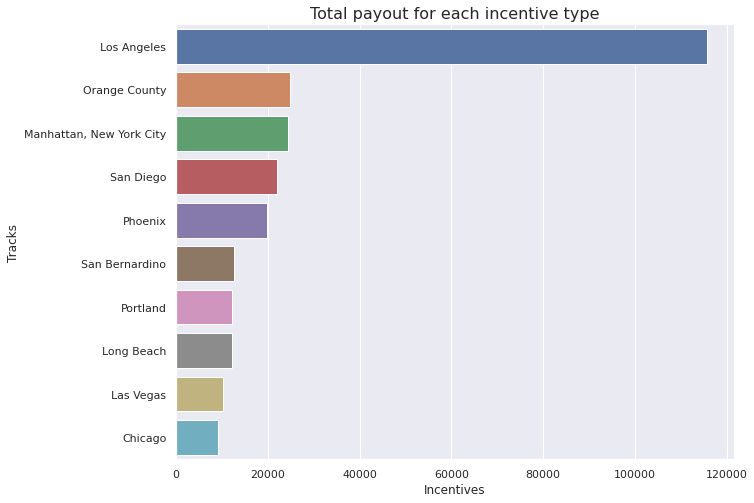

In [ ]:
locations=pd.DataFrame(df.groupby(by=["georegion_name"], dropna=False)['incentive_track_uuid'].nunique()).reset_index().sort_values(by='incentive_track_uuid', ascending=False).head(10)
sns.set(rc={'figure.figsize':(10,8)})
sns.color_palette("Blues", as_cmap=True)
sns.barplot(y="georegion_name", x="incentive_track_uuid", data=locations)
plt.ylabel("Tracks", fontsize=12)
plt.xlabel("Incentives",fontsize=12)
plt.title("Total payout for each incentive type",fontsize=16)

Text(0.5, 1.0, 'Enrollment time for each incentive type')

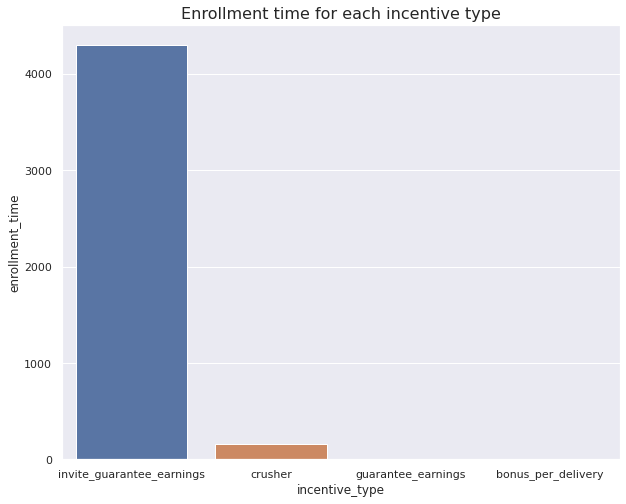

In [ ]:
#Duration of an incentive grouped by type
df['enrollment_time']=df['enroll_end_ts']-df['enroll_start_ts']
#Convert to hours.
df['enrollment_time']=df['enrollment_time'].dt.total_seconds()/3600

#Median enrollment period duration per incentive type.

enrollment=pd.DataFrame(df.groupby(by=["incentive_type"], dropna=False)['enrollment_time'].median()).reset_index().sort_values(by='enrollment_time', ascending=False)
sns.barplot(y="enrollment_time", x="incentive_type", data=enrollment)
plt.ylabel("enrollment_time", fontsize=12)
plt.xlabel("incentive_type",fontsize=12)
plt.title("Enrollment time for each incentive type",fontsize=16)

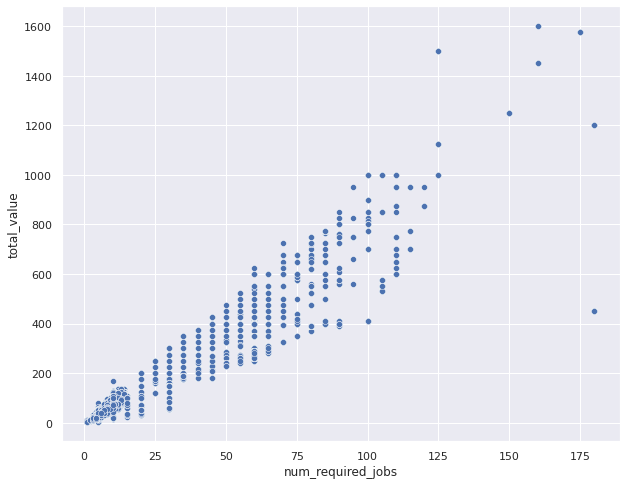

In [ ]:
#Average payout per driver groped by incentive type / view by region / 
sns.scatterplot(data=df, x="num_required_jobs", y="total_value")

In [ ]:
df=pd.read_csv('/content/last500.csv')
df=df.drop(['Unnamed: 0'], axis=1)

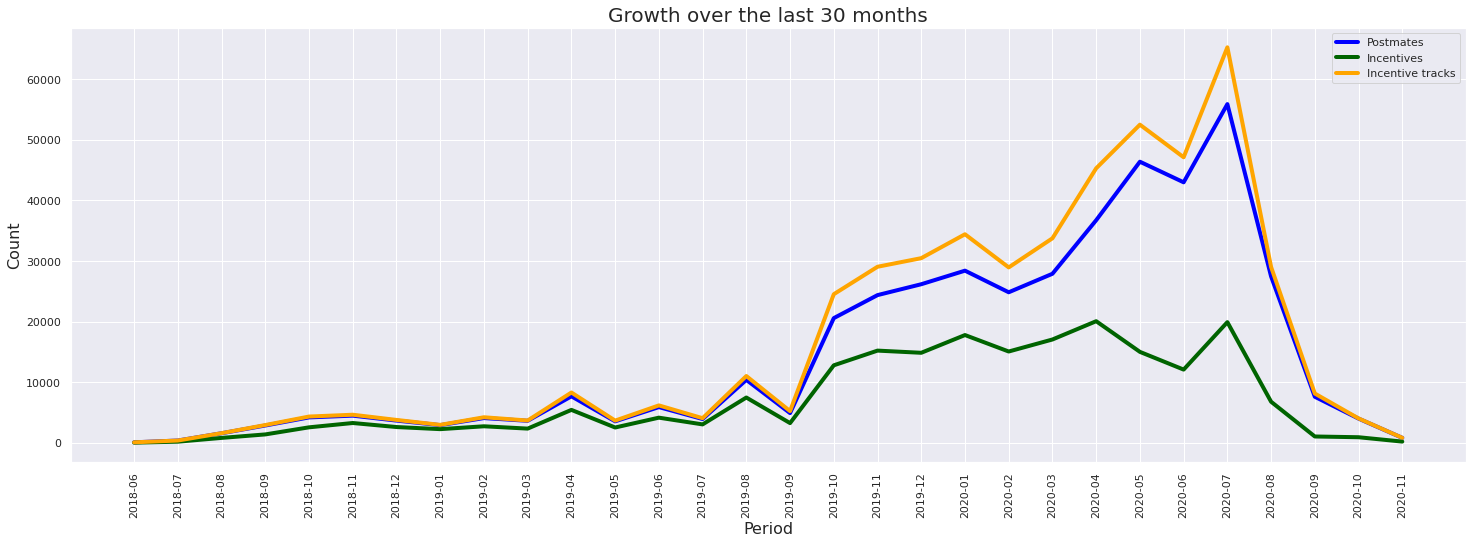

In [ ]:
#Create a column of date enrolled as datetime type.
df=df.sort_values(by=['create_ts'], ascending=False)
datetimes = pd.to_datetime(df['create_ts'])
df[['year','month','day']] = datetimes.dt.date.astype(str).str.split('-',expand=True)

df['Date_enrolled'] = df['year'].str.cat(df['month'],sep="-")
df['Date_enrolled'] = pd.to_datetime(df['Date_enrolled'])

df['Period']=df['year'].str.cat(df['month'],sep="-")

#Count each value per per month time period.
couries=pd.DataFrame(df.groupby(by=["Period"], dropna=False)['courier_uuid'].nunique()).sort_values(by='Period', ascending=True).reset_index()
incentives=pd.DataFrame(df.groupby(by=["Period"], dropna=False)['incentive_uuid'].nunique()).sort_values(by='Period', ascending=True).reset_index()
incentive_tracks=pd.DataFrame(df.groupby(by=["Period"], dropna=False)['incentive_track_uuid'].nunique()).sort_values(by='Period', ascending=True).reset_index()

#Create a unified dataframe.
growth_over_time=pd.DataFrame(columns=['Period','Postmates','Incentives','Incentive tracks'])
growth_over_time['Period'], growth_over_time['Postmates'], growth_over_time['Incentives'], growth_over_time['Incentive tracks'] = couries['Period'], couries['courier_uuid'], incentives['incentive_uuid'], incentive_tracks['incentive_track_uuid']
sns.set(rc={'figure.figsize':(25,8)})

#Create the plot.
plt.plot( 'Period', 'Postmates', data=growth_over_time, color='blue', linewidth=4, label='Postmates')
plt.plot( 'Period', 'Incentives', data=growth_over_time, color='darkgreen', linewidth=4, label='Incentives')
plt.plot( 'Period', 'Incentive tracks', data=growth_over_time, color='orange', linewidth=4, label="Incentive tracks")
plt.title('Growth over the last 30 months', fontsize=20)
plt.xlabel('Period',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.xticks(rotation=90) 
plt.legend()


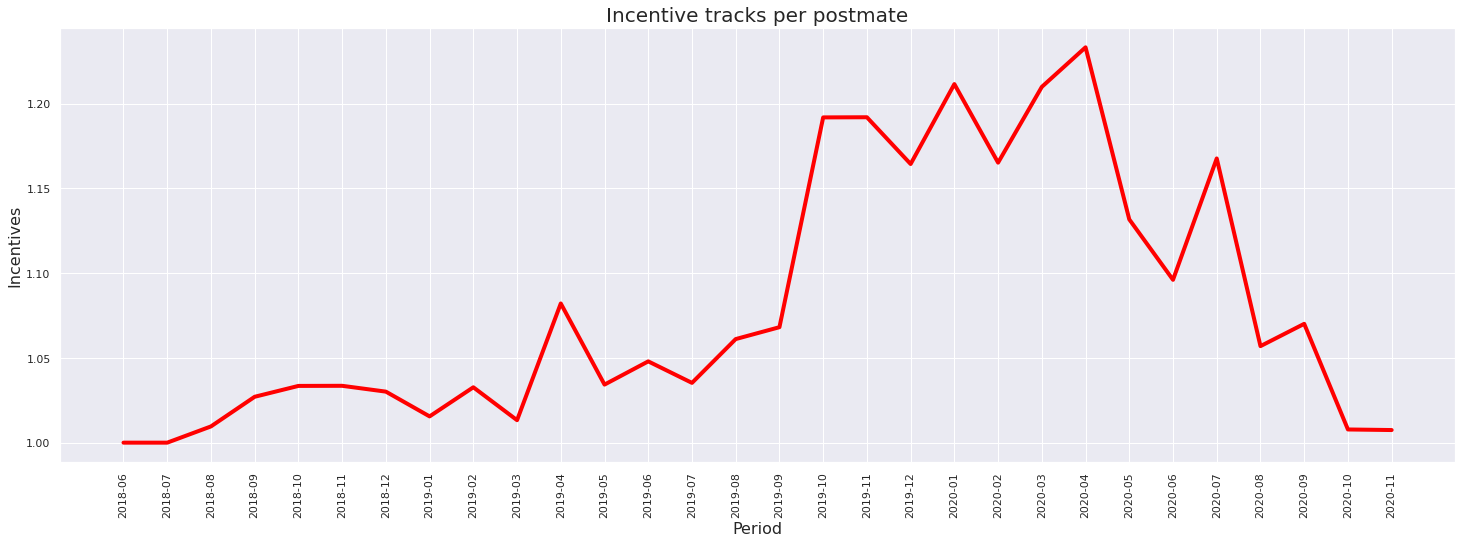

In [ ]:
growth_over_time['Incentive_tracks_per_postmate']=growth_over_time['Incentive tracks']/growth_over_time['Postmates']
plt.plot( 'Period', 'Incentive_tracks_per_postmate', data=growth_over_time, color='red', linewidth=4)
plt.title("Incentive tracks per postmate", fontsize=20)
plt.xlabel('Period',fontsize=16)
plt.ylabel('Incentives',fontsize=16)
plt.xticks(rotation=90) 
plt.show()

In [ ]:
active_postmates=df.groupby('courier_uuid')['incentive_uuid'].count().sort_values(ascending=False).reset_index()
active_postmates['incentive_uuid'].describe([.5,.9,.99,.999])

count    273806.000000
mean          1.826110
std           1.933697
min           1.000000
50%           1.000000
90%           3.000000
99%          10.000000
99.9%        19.000000
max         282.000000
Name: incentive_uuid, dtype: float64

(array([91., 28., 31.,  5.,  5.,  8.,  2.,  3.,  0.,  1.]),
 array([21. , 22.4, 23.8, 25.2, 26.6, 28. , 29.4, 30.8, 32.2, 33.6, 35. ]),
 <a list of 10 Patch objects>)

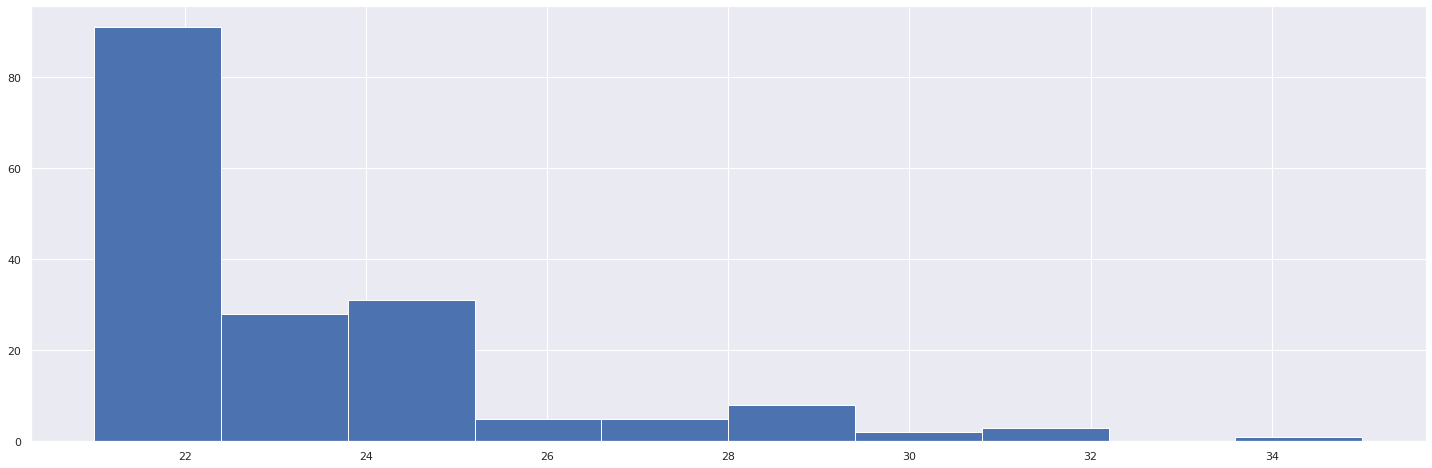

In [ ]:
super_active_users=active_postmates[active_postmates['incentive_uuid']>20]
super_active_users=super_active_users[super_active_users['incentive_uuid']<40]

plt.hist(super_active_users['incentive_uuid'])

In [ ]:
potential_fraud=active_postmates[active_postmates['incentive_uuid']>=40]
potential_fraud

,courier_uuid,incentive_uuid
0,732fba8e-5fe3-4f74-a552-307666c45aa8,282
1,603386db-1e57-4629-a4f0-90fee775224c,143
2,385453ff-795a-4532-b44b-13a454515602,104
3,db0a48ad-7636-4608-a351-48fefce427a6,69
4,dedd63aa-f1f4-4e35-88d7-b41ec06f366c,50
5,6c45870a-924b-4bcb-acdc-58dacc3ac133,49
6,d7b46b09-d3b4-4441-baee-bb1b00c20336,49


In [ ]:
potential_fraud=potential_fraud.head(1)
potential_fraud=list(potential_fraud['courier_uuid'])
potential_fraud=df.loc[df['courier_uuid'].isin(potential_fraud)]
potential_fraud=potential_fraud[['georegion_name']]
potential_fraud.groupby('georegion_name')['georegion_name'].count().sort_values(ascending=False).head(20)

georegion_name
Raleigh             18
San Antonio         15
Jacksonville        14
Kansas City         13
Tampa               13
Columbus            12
Salt Lake City      11
St. Louis           11
Tulsa                8
Albuquerque          7
Cleveland            7
Colorado Springs     6
Fresno               6
Providence RI        6
Virginia Beach       6
Visalia CA           5
Baltimore            5
Bakersfield          4
Westbury NY          4
Tucson               4
Name: georegion_name, dtype: int64

In [ ]:
df['completed']=df.complete_ts.notnull().astype('int')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


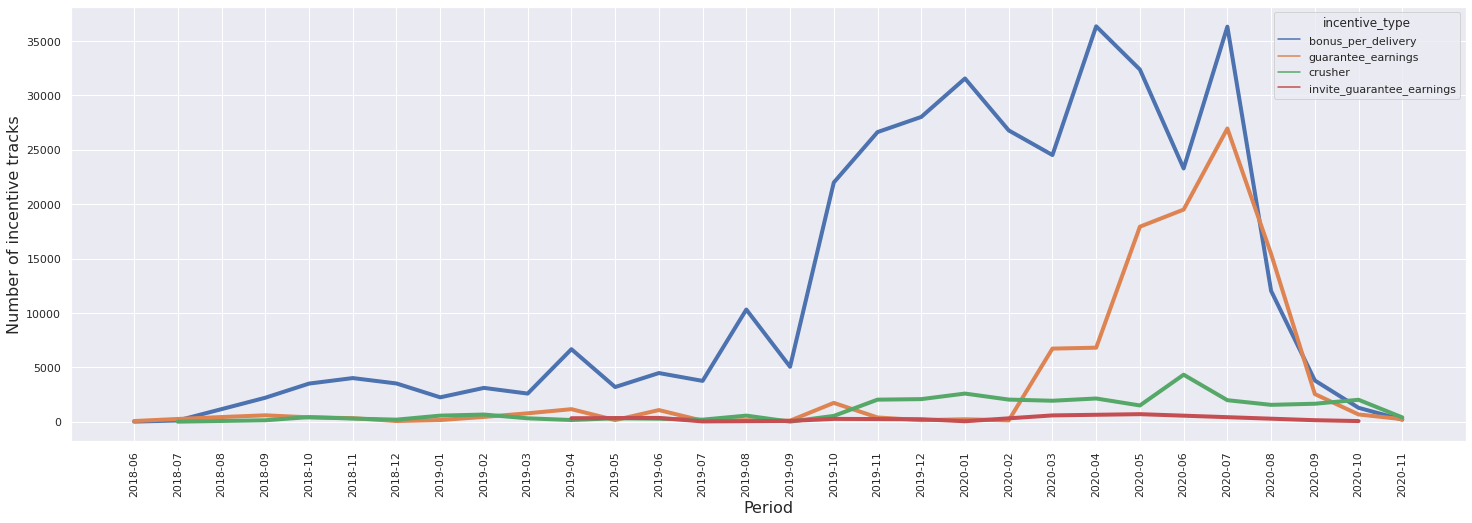

In [ ]:
#Different types of deliveries over time.
incentive_type_over_time=pd.DataFrame(df.groupby(['Period','incentive_type'])['incentive_track_uuid'].count()).reset_index()

sns.lineplot('Period', 'incentive_track_uuid', data=incentive_type_over_time, hue='incentive_type', linewidth=4)
plt.xlabel('Period',fontsize=16)
plt.ylabel('Number of incentive tracks',fontsize=16)
plt.xticks(rotation=90) 
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


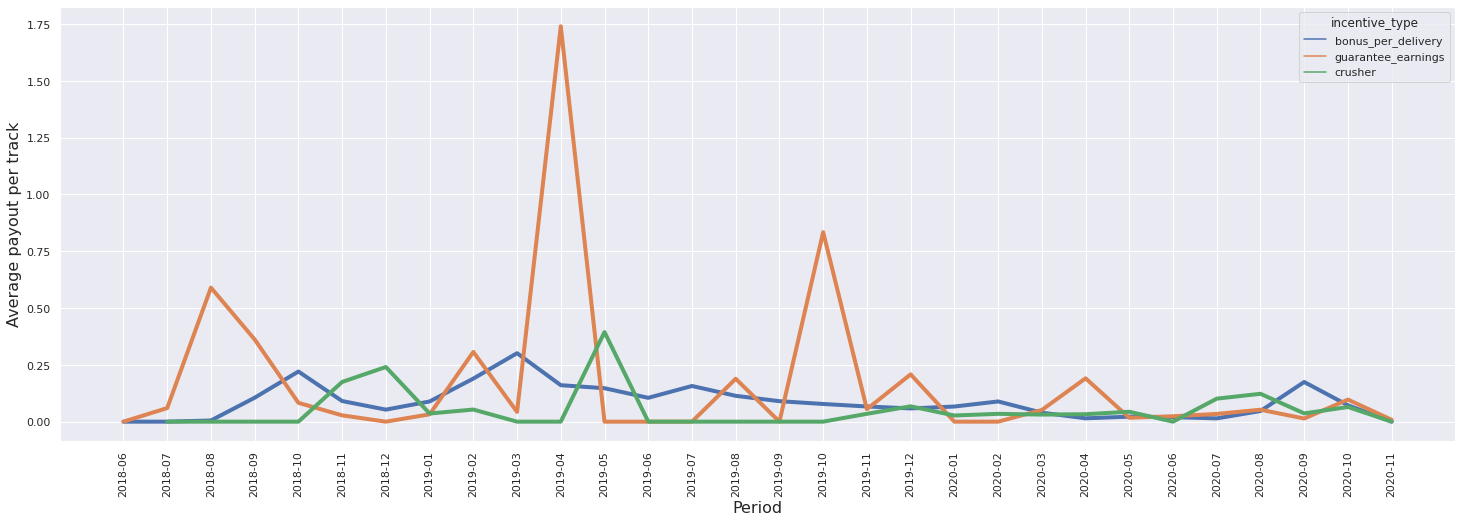

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


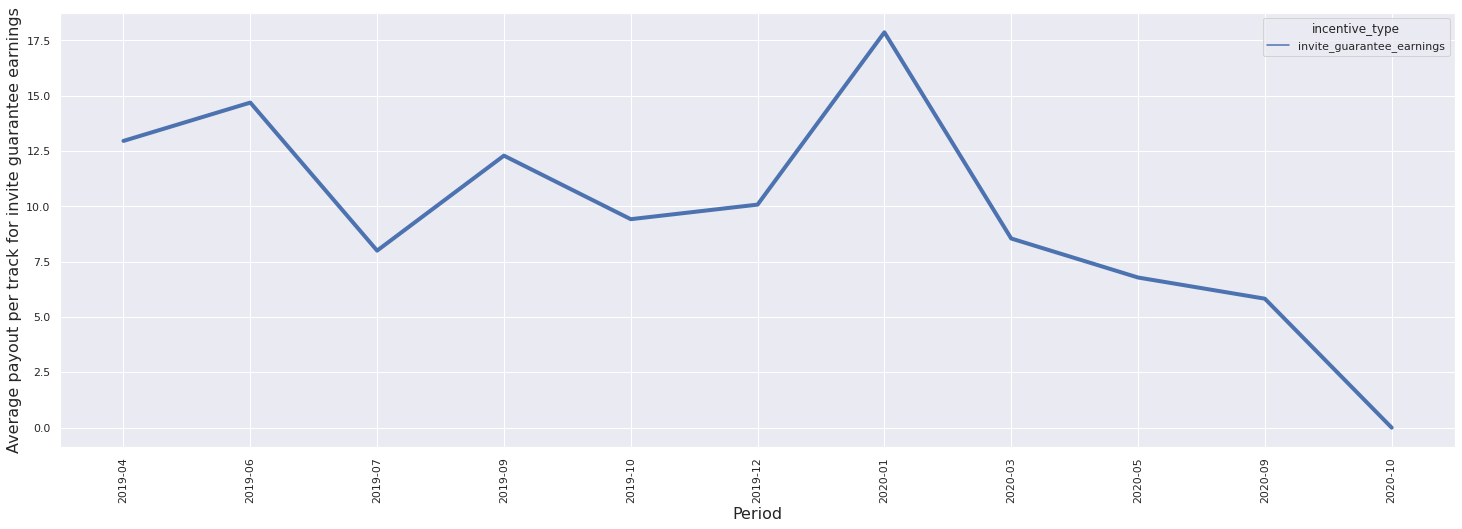

In [ ]:
payout_per_job=pd.DataFrame(df.groupby(['Period','incentive_type'])['payout_amount'].sum()).reset_index()
payout_per_job['number_of_tracks']=incentive_type_over_time['incentive_track_uuid']
payout_per_job['payout_per_incentive_track']=payout_per_job['payout_amount']/payout_per_job['number_of_tracks']

payout_per_job1=payout_per_job[payout_per_job['incentive_type']=='invite_guarantee_earnings']
payout_per_job2=payout_per_job[payout_per_job['incentive_type']!='invite_guarantee_earnings']


sns.lineplot('Period', 'payout_per_incentive_track', data=payout_per_job2, hue='incentive_type', linewidth=4)
plt.xlabel('Period',fontsize=16)
plt.ylabel('Average payout per track',fontsize=16)
plt.xticks(rotation=90) 
plt.show()

sns.lineplot('Period', 'payout_per_incentive_track', data=payout_per_job1, hue='incentive_type', linewidth=4)
plt.xlabel('Period',fontsize=16)
plt.ylabel('Average payout per track for invite guarantee earnings',fontsize=16)
plt.xticks(rotation=90) 
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


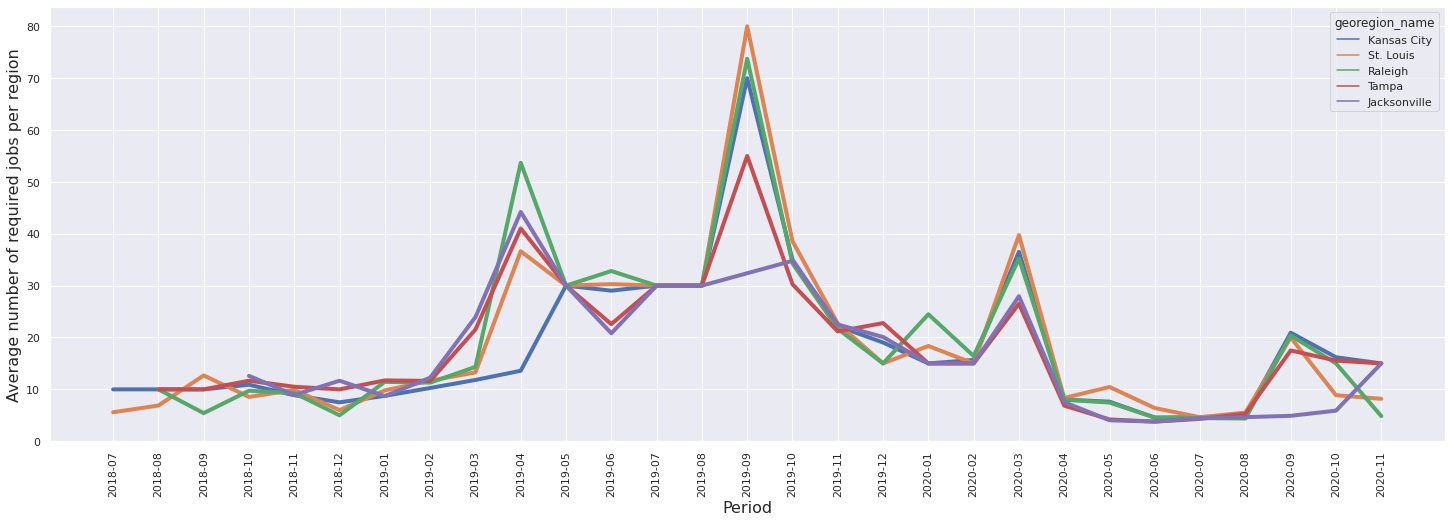

In [ ]:
#Different types of deliveries over time.
#Regions with the highest number of deliveries.
active_regions=pd.DataFrame(df.groupby(['georegion_name'])['incentive_track_uuid'].nunique()).sort_values(by='incentive_track_uuid', ascending=False).reset_index().head(5)
active_regions=list(active_regions['georegion_name'])


required_jobs=df[df['num_required_jobs'].notnull()]
required_jobs=required_jobs.loc[df['georegion_name'].isin(active_regions)]
required_jobs=pd.DataFrame(required_jobs.groupby(['Period','georegion_name'])['num_required_jobs'].mean()).reset_index()

sns.lineplot('Period', 'num_required_jobs', data=required_jobs, hue='georegion_name', linewidth=4)
plt.xlabel('Period',fontsize=16)
plt.ylabel('Average number of required jobs per region',fontsize=16)
plt.xticks(rotation=90) 
plt.show()

In [ ]:
completed=df.loc[df['complete_ts'].notnull()]

pd.DataFrame(completed.groupby(by=["incentive_type"], dropna=False)['incentive_track_uuid'].count()).reset_index().sort_values(by='incentive_track_uuid', ascending=False)

,incentive_type,incentive_track_uuid
1,guarantee_earnings,696
2,invite_guarantee_earnings,145
0,crusher,26


In [ ]:
notcompleted=df.loc[df['complete_ts'].isnull()]
notcompleted

pd.DataFrame(df.groupby(by=["incentive_type"], dropna=False)['incentive_track_uuid'].count()).reset_index().sort_values(by='incentive_track_uuid', ascending=False)

,incentive_type,incentive_track_uuid
0,bonus_per_delivery,360967
2,guarantee_earnings,105525
1,crusher,30756
3,invite_guarantee_earnings,2752
